In [2]:
#hide
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [3]:
#hide
from fastbook import *

In [4]:
from fastai.vision.all import *
path = Path('/content/gdrive/My Drive/Deep/Stone/')

In [5]:
train_fnames = get_image_files(path/"Train")

In [6]:
augs = [RandomResizedCropGPU(size=224, min_scale=0.75), Rotate(), Zoom()]
dblock = DataBlock(blocks=(ImageBlock(cls=PILImage), CategoryBlock),
                   splitter=RandomSplitter(valid_pct=0.2, seed=23),
                   get_y=parent_label,
                   item_tfms=Resize(512, method="squish"),
                   batch_tfms=augs,
                   )

dls = dblock.dataloaders(train_fnames)


In [7]:
train_df = len(train_fnames)
print(f"There are {train_df} images")

There are 1453 images


In [8]:
# print class names, number of class, length of train dataset, and length of valid dataset
dls.c, len(dls.train_ds), len(dls.valid_ds)

(2, 1163, 290)

In [9]:
dls.vocab



['Kidney_stone', 'Normal']

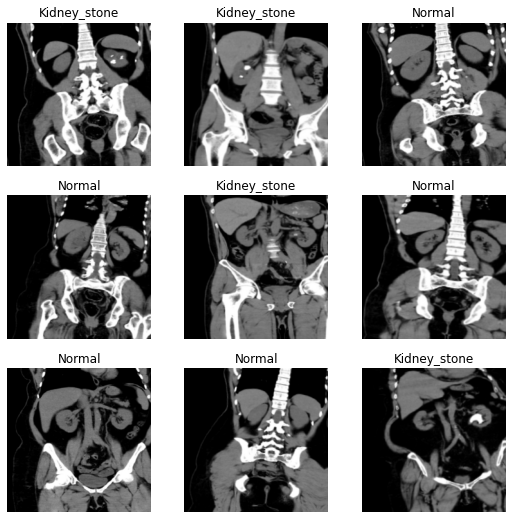

In [10]:
dls.show_batch()

In [11]:
model = nn.Sequential(create_body(xresnet50, pretrained=False),create_head(nf=2048, n_out=2))
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=accuracy)



In [ ]:
#learn = cnn_learner(dls, resnet34, metrics=accuracy)

In [ ]:
#learn.lr_find()

In [12]:
learn.fit_one_cycle(40,1e-2)
#learn.fine_tune(30)

epoch,train_loss,valid_loss,accuracy,time
0,0.815017,1.368780,0.403448,06:07
1,0.764600,0.830080,0.486207,00:40
2,0.734295,0.663450,0.617241,00:40
3,0.704050,0.714246,0.513793,00:39
4,0.674893,4.563618,0.403448,00:40
5,0.635104,3.541168,0.403448,00:40
6,0.591084,7.456542,0.403448,00:40
7,0.552908,2.091071,0.565517,00:40
8,0.520331,25.976387,0.403448,00:40
9,0.480541,0.387135,0.813793,00:40


In [13]:
learn.save(path/'kidney-50')

Path('/content/gdrive/My Drive/Deep/Stone/kidney-50.pth')

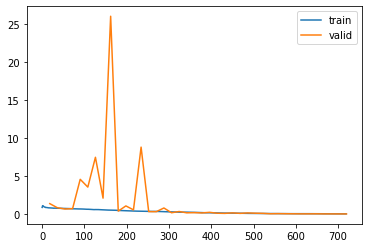

In [14]:
learn.recorder.plot_loss(skip_start=0, with_valid=True)

In [15]:
test_items = get_image_files(path/"Test")
all_files= get_image_files(path)

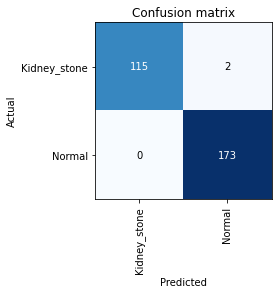

In [16]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()


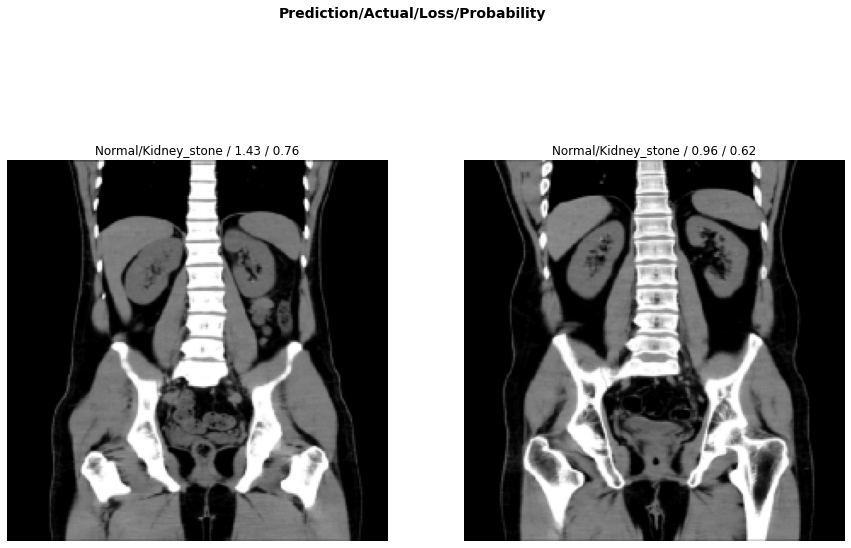

In [17]:
interp.plot_top_losses(2, figsize=(15,10))

In [ ]:
interp.most_confused()

[('Normal', 'Kidney_stone', 4), ('Kidney_stone', 'Normal', 3)]

In [ ]:
#losses,idxs = interp.top_losses(10)
#print(idxs)

In [ ]:
#dls.valid_ds.items[77]

TEST set

In [18]:

augs = [RandomResizedCropGPU(size=224, min_scale=0.75), Rotate(), Zoom()]
dblock = DataBlock(blocks=(ImageBlock(cls=PILImage), CategoryBlock),
                   splitter=GrandparentSplitter(train_name='Train', valid_name='Test'),
                   get_y=parent_label,
                   item_tfms=Resize(512, method="squish"),
                   batch_tfms=augs,
                   )

dls_test = dblock.dataloaders(all_files)



In [ ]:
print("Number of examples in testing:", len(dls_test.valid_ds))

Number of examples in testing: 346


In [19]:
learn1 = learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=accuracy).load('/content/gdrive/My Drive/Deep/Stone/kidney-50')

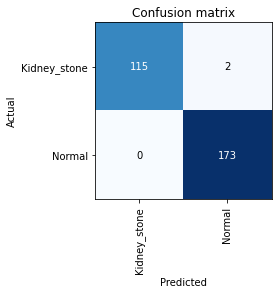

In [20]:
interp = ClassificationInterpretation.from_learner(learn1)
interp.plot_confusion_matrix()


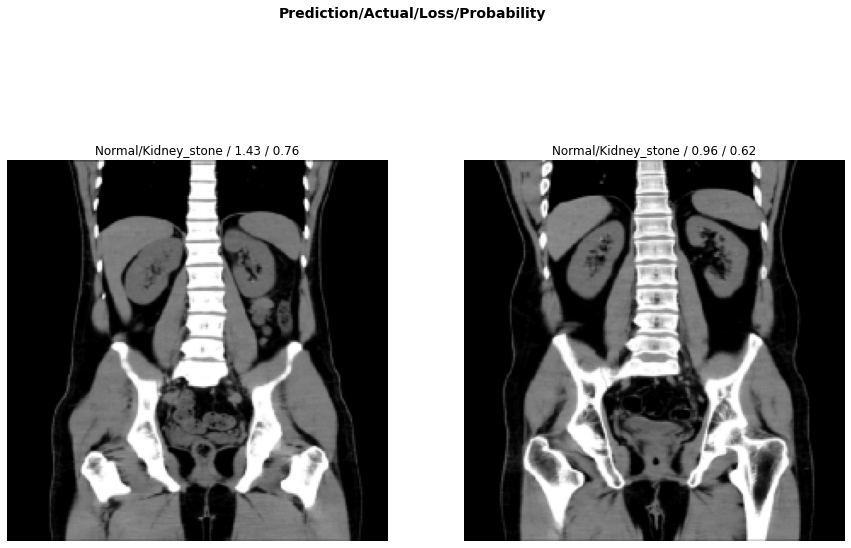

In [22]:
interp.plot_top_losses(2, figsize=(15,10))

In [23]:
interp.print_classification_report()

              precision    recall  f1-score   support

Kidney_stone       1.00      0.98      0.99       117
      Normal       0.99      1.00      0.99       173

    accuracy                           0.99       290
   macro avg       0.99      0.99      0.99       290
weighted avg       0.99      0.99      0.99       290



In [24]:
interp.most_confused()

[('Kidney_stone', 'Normal', 2)]

In [25]:
losses,idxs = interp.top_losses(2)
print(idxs)

TensorBase([ 61, 157])


In [ ]:
dls_test.valid_ds.items[98]

Path('/content/gdrive/My Drive/Deep/Stone/Test/Normal/1.3.46.670589.33.1.63717277033531901200001.5586510682377772363.png')

In [ ]:
img = PILImage.create(uploader.data[0])
is_kidney_stone,_,probs = learn.predict(img)
print(f"Is this a Kidney Stone?: {is_kidney_stone}")
print(f"Probability it's a Kidney stone: {probs[0].item():.2f}")

Is this a Kidney Stone?: Kidney_stone
Probability it's a Kidney stone: 1.00


In [26]:
class HookActivation():
    def __init__(self, target_layer):
        """Initialize a Pytorch hook using `hook_activation` function."""

        self.hook = target_layer.register_forward_hook(self.hook_activation) 
        
    def hook_activation(self, target_layer, activ_in, activ_out): 
        """Create a copy of the layer output activations and save 
        in `self.stored`.
        """
        self.stored = activ_out.detach().clone()
        
    def __enter__(self, *args): 
        return self
    
    def __exit__(self, *args): 
        self.hook.remove()

        
class HookGradient():
    def __init__(self, target_layer):
        """Initialize a Pytorch hook using `hook_gradient` function."""
        
        self.hook = target_layer.register_backward_hook(self.hook_gradient)   
        
    def hook_gradient(self, target_layer, gradient_in, gradient_out): 
        """Create a copy of the layer output gradients and save 
        in `self.stored`.
        """
        self.stored = gradient_out[0].detach().clone()
        
    def __enter__(self, *args): 
        return self

    def __exit__(self, *args): 
        self.hook.remove()

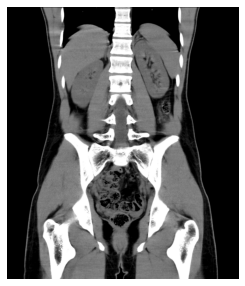

In [27]:
img = PILImage.create(path/'Test'/'Normal'/'1.3.46.670589.33.1.63716501098226062100001.4658552781845351680.png')
img1 = PILImage.create(path/'Test'/'Kidney_stone'/'1.3.46.670589.33.1.63713381202237054300001.5283382789026321582.png')
img2 = PILImage.create(path/'Test'/'Kidney_stone'/'1.3.46.670589.33.1.63713387527329822700001.5157862012658596403.png')
img3 = PILImage.create(path/'Test'/'Kidney_stone'/'1.3.46.670589.33.1.63713387527194814900001.5284550079795702563.png')
img.show()



In [28]:
learn1.summary()

Sequential (Input shape: 64)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 32 x 112 x 112 
Conv2d                                    864        True      
BatchNorm2d                               64         True      
ReLU                                                           
Conv2d                                    9216       True      
BatchNorm2d                               64         True      
ReLU                                                           
____________________________________________________________________________
                     64 x 64 x 112 x 112 
Conv2d                                    18432      True      
BatchNorm2d                               128        True      
ReLU                                                           
MaxPool2d                                                      
Conv2d                                    4096       True      
BatchNorm2d                               

In [29]:
m = learn1.model.eval();
m;

In [30]:
target_layer = learn1.model[0][7][2]

target_layer;

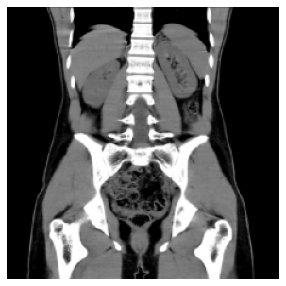

In [31]:
x, = first(dls_test.test_dl([img]))

x_img = TensorImage(dls_test.train.decode((x,))[0][0])
x_img.show()


In [32]:
learn1.predict(img)

('Normal', tensor(1), tensor([0.0012, 0.9988]))

In [33]:
dls_test.vocab

['Kidney_stone', 'Normal']

In [34]:
class_Z = 1

with HookGradient(target_layer) as hookg:
    with HookActivation(target_layer) as hook:
        output = learn1.model.eval()(x.cuda())
        act = hook.stored
    output[0, class_Z].backward()
    grad = hookg.stored
    p0, p1 = output.cpu().detach()[0]

In [35]:
w = grad[0].mean(dim=(1,2), keepdim=True)
gradcam_map = (w * act[0]).sum(0).detach().cpu()

In [36]:
def plot_gradcam(img, learn1, hooked_layer, size=224):
    
    fig, axes = plt.subplots(1, 3, sharey=True, figsize=(8.5, 3), dpi=150)

    x_img = TensorImage(dls_test.train.decode((x,))[0][0])
    
    
    for i, ax in zip([0, 2, 1], axes):

        if i == 0:
            x_img.show(ax=ax)
            ax.set_axis_off()
            continue

        with HookGradient(hooked_layer) as hookg:
            with HookActivation(hooked_layer) as hook:
                output = learn1.model.eval()(x.cuda())
                act = hook.stored
            output[0, i-1].backward()
            grad = hookg.stored
            p_high, p_low = output.cpu().detach()[0]

        w = grad[0].mean(dim=(1,2), keepdim=True)
        gradcam_map = (w * act[0]).sum(0).detach().cpu()

        # thresholding to account for ReLU
        gradcam_map = torch.clamp(gradcam_map, min=0) 

        x_img.show(ax=ax)
        ax.imshow(
            gradcam_map, alpha=0.6, extent=(0, size, size,0),
            interpolation='mitchell', cmap='hot'
        )
        ax.set_axis_off()
            
    fig.tight_layout()
    fig.subplots_adjust(wspace=0.02)
    
    return (fig, axes, *(np.exp([p_low, p_high]) / np.exp([p_low, p_high]).sum()))

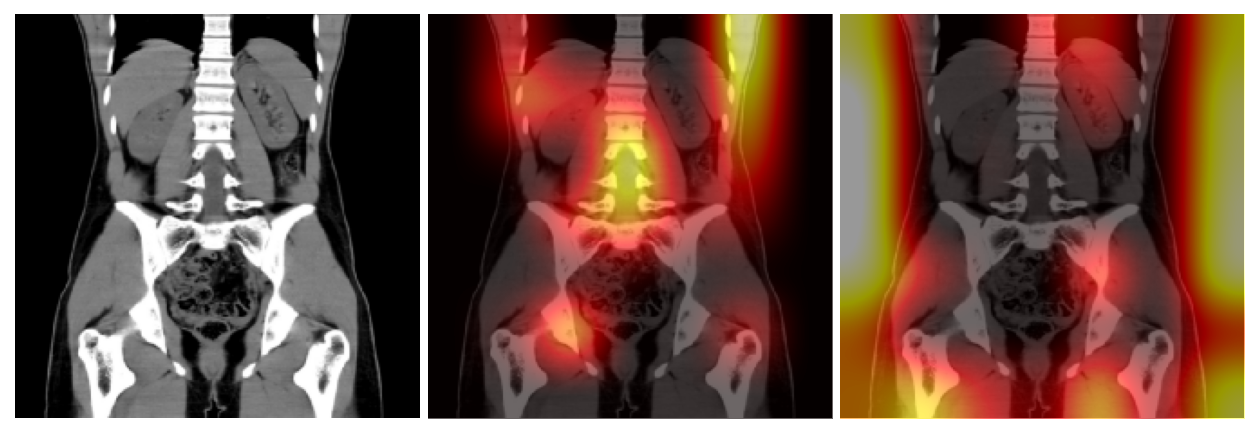

In [37]:
plot_gradcam(x_img,learn1,target_layer);

In [38]:
img = PILImage.create(path/'Test'/'Kidney_stone'/'1.3.46.670589.33.1.63713381202237054300001.5283382789026321582.png')

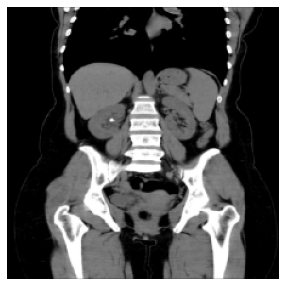

In [39]:
x, = first(dls_test.test_dl([img]))

x_img = TensorImage(dls_test.train.decode((x,))[0][0])
x_img.show()

In [41]:
class_Z = 0

with HookGradient(target_layer) as hookg:
    with HookActivation(target_layer) as hook:
        output = learn1.model.eval()(x.cuda())
        act = hook.stored
    output[0, class_Z].backward()
    grad = hookg.stored
    p0, p1 = output.cpu().detach()[0]

w = grad[0].mean(dim=(1,2), keepdim=True)
gradcam_map = (w * act[0]).sum(0).detach().cpu()
def plot_gradcam(img, learn1, hooked_layer, size=224):
    
    fig, axes = plt.subplots(1, 3, sharey=True, figsize=(8.5, 3), dpi=150)

    x_img = TensorImage(dls_test.train.decode((x,))[0][0])
    
    
    for i, ax in zip([0, 2, 1], axes):

        if i == 0:
            x_img.show(ax=ax)
            ax.set_axis_off()
            continue

        with HookGradient(hooked_layer) as hookg:
            with HookActivation(hooked_layer) as hook:
                output = learn1.model.eval()(x.cuda())
                act = hook.stored
            output[0, i-1].backward()
            grad = hookg.stored
            p_high, p_low = output.cpu().detach()[0]

        w = grad[0].mean(dim=(1,2), keepdim=True)
        gradcam_map = (w * act[0]).sum(0).detach().cpu()

        # thresholding to account for ReLU
        gradcam_map = torch.clamp(gradcam_map, min=0) 

        x_img.show(ax=ax)
        ax.imshow(
            gradcam_map, alpha=0.6, extent=(0, size, size,0),
            interpolation='mitchell', cmap='hot'
        )
        ax.set_axis_off()
            
    fig.tight_layout()
    fig.subplots_adjust(wspace=0.02)
    
    return (fig, axes, *(np.exp([p_low, p_high]) / np.exp([p_low, p_high]).sum()))



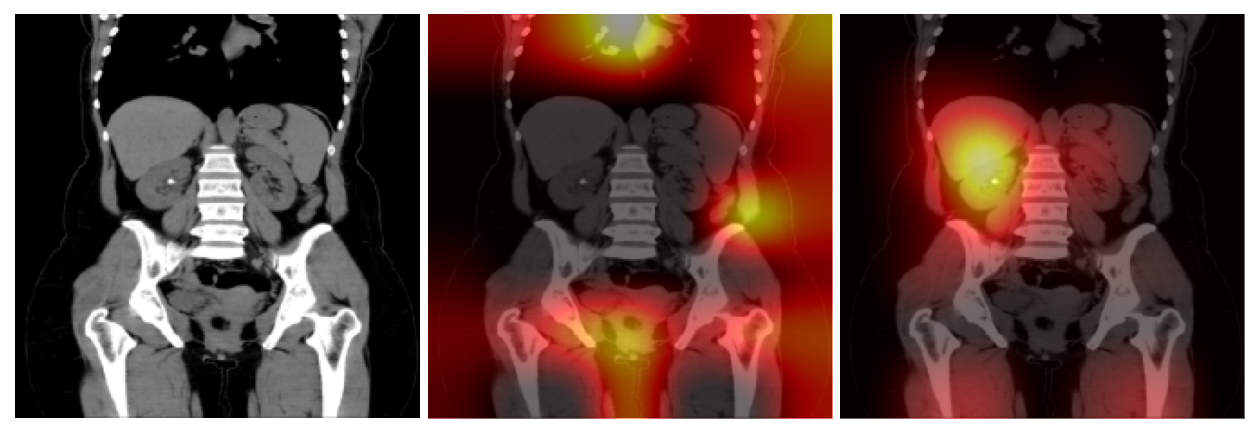

In [42]:
plot_gradcam(x_img,learn1,target_layer);

In [43]:
img = PILImage.create(path/'Test'/'Kidney_stone'/'1.3.46.670589.33.1.63713387527329822700001.5157862012658596403.png')

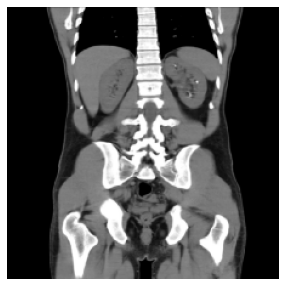

In [44]:
x, = first(dls_test.test_dl([img]))

x_img = TensorImage(dls_test.train.decode((x,))[0][0])
x_img.show()

In [45]:
class_Z = 0

with HookGradient(target_layer) as hookg:
    with HookActivation(target_layer) as hook:
        output = learn1.model.eval()(x.cuda())
        act = hook.stored
    output[0, class_Z].backward()
    grad = hookg.stored
    p0, p1 = output.cpu().detach()[0]

w = grad[0].mean(dim=(1,2), keepdim=True)
gradcam_map = (w * act[0]).sum(0).detach().cpu()
def plot_gradcam(img, learn1, hooked_layer, size=224):
    
    fig, axes = plt.subplots(1, 3, sharey=True, figsize=(8.5, 3), dpi=150)

    x_img = TensorImage(dls_test.train.decode((x,))[0][0])
    
    
    for i, ax in zip([0, 2, 1], axes):

        if i == 0:
            x_img.show(ax=ax)
            ax.set_axis_off()
            continue

        with HookGradient(hooked_layer) as hookg:
            with HookActivation(hooked_layer) as hook:
                output = learn1.model.eval()(x.cuda())
                act = hook.stored
            output[0, i-1].backward()
            grad = hookg.stored
            p_high, p_low = output.cpu().detach()[0]

        w = grad[0].mean(dim=(1,2), keepdim=True)
        gradcam_map = (w * act[0]).sum(0).detach().cpu()

        # thresholding to account for ReLU
        gradcam_map = torch.clamp(gradcam_map, min=0) 

        x_img.show(ax=ax)
        ax.imshow(
            gradcam_map, alpha=0.6, extent=(0, size, size,0),
            interpolation='mitchell', cmap='hot'
        )
        ax.set_axis_off()
            
    fig.tight_layout()
    fig.subplots_adjust(wspace=0.02)
    
    return (fig, axes, *(np.exp([p_low, p_high]) / np.exp([p_low, p_high]).sum()))

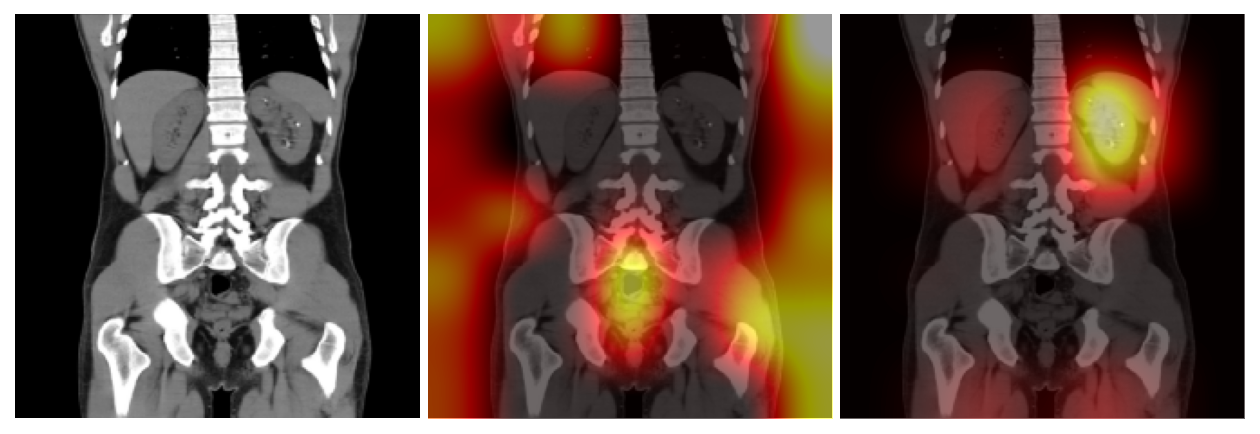

In [46]:
plot_gradcam(x_img,learn1,target_layer);

In [47]:
img = PILImage.create(path/'Test'/'Kidney_stone'/'1.3.46.670589.33.1.63713387527194814900001.5284550079795702563.png')

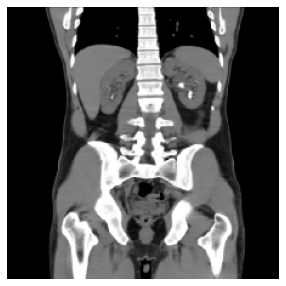

In [48]:
x, = first(dls_test.test_dl([img]))

x_img = TensorImage(dls_test.train.decode((x,))[0][0])
x_img.show()

In [49]:
class_Z = 0

with HookGradient(target_layer) as hookg:
    with HookActivation(target_layer) as hook:
        output = learn1.model.eval()(x.cuda())
        act = hook.stored
    output[0, class_Z].backward()
    grad = hookg.stored
    p0, p1 = output.cpu().detach()[0]

w = grad[0].mean(dim=(1,2), keepdim=True)
gradcam_map = (w * act[0]).sum(0).detach().cpu()
def plot_gradcam(img, learn1, hooked_layer, size=224):
    
    fig, axes = plt.subplots(1, 3, sharey=True, figsize=(8.5, 3), dpi=150)

    x_img = TensorImage(dls_test.train.decode((x,))[0][0])
    
    
    for i, ax in zip([0, 2, 1], axes):

        if i == 0:
            x_img.show(ax=ax)
            ax.set_axis_off()
            continue

        with HookGradient(hooked_layer) as hookg:
            with HookActivation(hooked_layer) as hook:
                output = learn1.model.eval()(x.cuda())
                act = hook.stored
            output[0, i-1].backward()
            grad = hookg.stored
            p_high, p_low = output.cpu().detach()[0]

        w = grad[0].mean(dim=(1,2), keepdim=True)
        gradcam_map = (w * act[0]).sum(0).detach().cpu()

        # thresholding to account for ReLU
        gradcam_map = torch.clamp(gradcam_map, min=0) 

        x_img.show(ax=ax)
        ax.imshow(
            gradcam_map, alpha=0.6, extent=(0, size, size,0),
            interpolation='mitchell', cmap='hot'
        )
        ax.set_axis_off()
            
    fig.tight_layout()
    fig.subplots_adjust(wspace=0.02)
    
    return (fig, axes, *(np.exp([p_low, p_high]) / np.exp([p_low, p_high]).sum()))

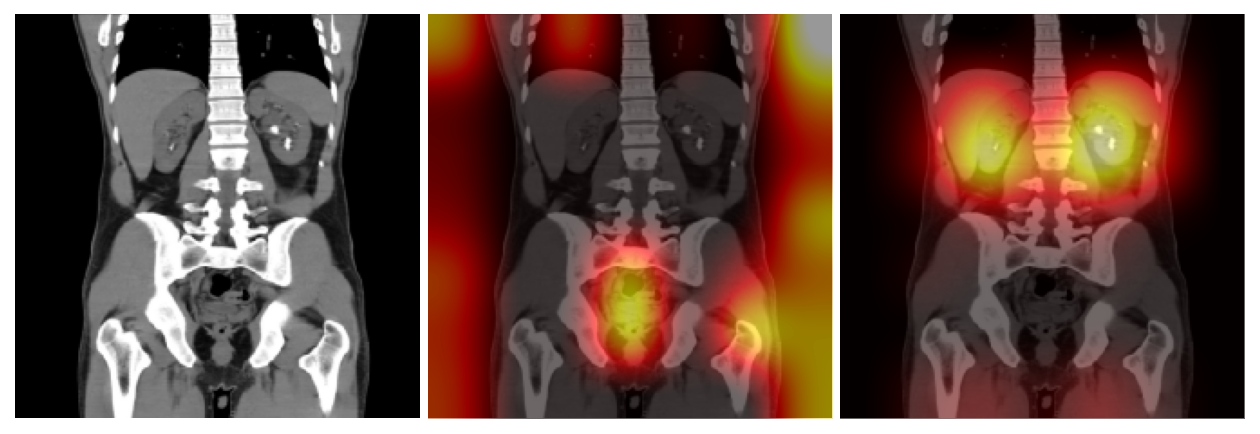

In [50]:
plot_gradcam(x_img,learn1,target_layer);